In [1]:
%load_ext autoreload
%autoreload 2

from aeon.datasets import load_classification

import numpy as np
import pandas as pd
import pickle
import torch
import random
import csv

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import seaborn as sns
from sklearn import metrics
import squarify

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from weights_parser import WeightsParser
from models import LogisticRegressionWithSummariesAndBottleneck_Wrapper
from custom_losses import custom_bce_horseshoe
from preprocess_helpers import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.functional import binary_cross_entropy_with_logits
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from torchmetrics import AUROC, Accuracy

from itertools import combinations

from tqdm import tqdm
from time import sleep
from helper import *
import collections
import optuna
from optuna.trial import TrialState
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_timeline
import os
import helper

In [2]:
X, y, meta_data = load_classification("SpokenArabicDigits", extract_path="/workdir/optimal-summaries-public/data")
print(" Shape of X = ", len(X), X[0].shape)
print(" Shape of y = ", y.shape)
print(" Meta data = ", meta_data)
y = y.astype(int)
y


 Shape of X =  8798 (13, 38)
 Shape of y =  (8798,)
 Meta data =  {'problemname': 'spokenarabicdigits', 'timestamps': False, 'missing': False, 'univariate': False, 'equallength': False, 'classlabel': True, 'targetlabel': False, 'class_values': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']}


array([ 1,  1,  1, ..., 10, 10, 10])

In [3]:
lengths = []
for c, x in enumerate(X):
    lengths.append(x.shape[1])
lengths.sort()

MIN_TS_SIZE = min(lengths)
MAX_TS_SIZE = max(lengths)

print(MIN_TS_SIZE, MAX_TS_SIZE)

counter = collections.Counter(lengths)
counter


4 93


Counter({4: 1,
         7: 2,
         9: 3,
         11: 1,
         12: 2,
         13: 3,
         14: 6,
         15: 10,
         16: 6,
         17: 8,
         18: 8,
         19: 13,
         20: 13,
         21: 23,
         22: 33,
         23: 57,
         24: 67,
         25: 75,
         26: 102,
         27: 110,
         28: 113,
         29: 164,
         30: 225,
         31: 254,
         32: 297,
         33: 382,
         34: 367,
         35: 378,
         36: 403,
         37: 485,
         38: 444,
         39: 484,
         40: 431,
         41: 388,
         42: 343,
         43: 342,
         44: 353,
         45: 317,
         46: 320,
         47: 260,
         48: 223,
         49: 173,
         50: 196,
         51: 149,
         52: 114,
         53: 93,
         54: 104,
         55: 77,
         56: 82,
         57: 66,
         58: 50,
         59: 44,
         60: 33,
         61: 24,
         62: 17,
         63: 9,
         64: 11,
         65: 3,
 

In [4]:
def preprocess_data_binary(X, target):
    equi_length_X = []
    for x in X:
        pad_width = ((0, 0), (0, MAX_TS_SIZE - x.shape[1]))
        padded = np.pad(x, pad_width, mode='constant', constant_values=0)
        equi_length_X.append(padded)

    equi_length_X = np.array(equi_length_X)
    equi_length_X = equi_length_X.swapaxes(1,2)
    
    indicators_3d = ~np.isnan(equi_length_X)

    data = np.concatenate([equi_length_X, indicators_3d], axis=-1)
    
    ## target
    # convert problem to 1 vs all
    _y = np.copy(target)
    _y[_y > 1] = 0
    
    # convert y to logits
    y_logits = np.vstack([(~_y.astype(bool)).astype(int), _y])
    y_logits = np.swapaxes(y_logits, 0, 1)
    
    # weights
    pos_prop = np.mean(np.array(y_logits)[:, 1])
    p_weight = torch.Tensor([1 / (1 - pos_prop), 1 / pos_prop]).cuda()
    
    return data, y_logits, p_weight

def preprocess_data_multiclass(X, target):
    equi_length_X = []
    for x in X:
        pad_width = ((0, 0), (0, MAX_TS_SIZE - x.shape[1]))
        padded = np.pad(x, pad_width, mode='constant', constant_values=0)
        equi_length_X.append(padded)

    equi_length_X = np.array(equi_length_X)
    equi_length_X = equi_length_X.swapaxes(1,2)
    
    indicators_3d = ~np.isnan(equi_length_X)

    data = np.concatenate([equi_length_X, indicators_3d], axis=-1) # (N x ts_length x 2*changing_dim)
    
    ## target
    _y = np.copy(target)
    y_unique = np.unique(_y)
    num_classes = len(y_unique)
    
    # initiazing datasets
    weights = compute_class_weight(class_weight='balanced', classes=y_unique, y=_y)
    weights = torch.Tensor(weights).cuda()
    
    # 1 hot encode
    y_one_hot = np.eye(num_classes)[_y-1]
    
    return data, y_one_hot, num_classes, weights

In [5]:
def tensor_wrap(x, klass=torch.Tensor):
    return x if 'torch' in str(type(x)) else klass(x)

def initializeData(r, _X, _y):   
    
    # train-test-split
    torch.set_printoptions(sci_mode=False)
    X_train, X_test, y_train, y_test = train_test_split(_X, _y, test_size = 0.15, random_state = r, stratify = _y)

    # train-val split
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = r, stratify = y_train)

    X_train_pt = Variable(tensor_wrap(X_train)).cuda()
    y_train_pt = Variable(tensor_wrap(y_train, torch.FloatTensor)).cuda()

    X_val_pt = Variable(tensor_wrap(X_val)).cuda()
    y_val_pt = Variable(tensor_wrap(y_val, torch.FloatTensor)).cuda()

    X_test_pt = Variable(tensor_wrap(X_test)).cuda()
    y_test_pt = Variable(tensor_wrap(y_test, torch.FloatTensor)).cuda()

    batch_size = 128

    train_dataset = TensorDataset(X_train_pt, y_train_pt)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    val_dataset = TensorDataset(X_val_pt, y_val_pt)
    val_loader = DataLoader(val_dataset, batch_size = X_val_pt.shape[0], shuffle=True, num_workers=0)

    # test_dataset = TensorDataset(X_test_pt, y_test_pt)
    # test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    return train_loader, val_loader, X_test_pt, y_test_pt


In [6]:
def init_cutoffs_to_zero(d):
    return np.zeros(d)


In [7]:
# init the upper and lower thresholds to random values
def init_rand_upper_thresholds(d):
    return np.random.rand(d)

def init_rand_lower_thresholds(d):
    return np.random.rand(d) - 1


In [8]:
def initializeModel(c, input_dim, changing_dim, time_len, output_dim = 2):
    logregbottleneck = LogisticRegressionWithSummariesAndBottleneck_Wrapper(input_dim, 
                                                changing_dim, 
                                                9,                     
                                                c,
                                                True,
                                                init_cutoffs_to_zero, 
                                                init_rand_lower_thresholds, 
                                                init_rand_upper_thresholds,
                                                cutoff_times_temperature=0.1,
                                                cutoff_times_init_values=None,
                                                time_len=time_len,
                                                opt_lr = 2e-4,
                                                opt_weight_decay = 2e-05,
                                                l1_lambda=0.001,
                                                cos_sim_lambda=0.01,
                                                output_dim = output_dim
                                                )
    logregbottleneck.cuda()
    return logregbottleneck

In [9]:
def set_seed(r):
    torch.backends.cudnn.deterministic = True
    random.seed(r)
    torch.manual_seed(r)
    torch.cuda.manual_seed(r)
    np.random.seed(r)


In [10]:
def objective_binary(r, num_concept, model_path):
    set_seed(r)
    data, y_logits, weights = preprocess_data_binary(X, y)
    input_dim = data.shape[2]
    changing_dim = X[0].shape[0]
    ts_length = data.shape[1]
    train_loader, val_loader, X_test, y_test = initializeData(1, data, y_logits)
    model = initializeModel(num_concept, input_dim, changing_dim, ts_length)
    
    train_loss, val_loss = model.fit(train_loader, val_loader, weights, model_path.format(num_concept), 1000)
    
    preds = model(tensor_wrap(X_test))
    
    auroc = AUROC(task="binary").cuda()
    auc = auroc(preds, y_test).item()
    
    accuracy = Accuracy(task="binary").cuda()
    acc = accuracy(preds, y_test).item()
    
    return val_loss, auc, acc, model

def objective_multi_class(r, num_concept, model_path):
    set_seed(r)
    data, y_ohe, num_classes, weights = preprocess_data_multiclass(X, y)
    input_dim = data.shape[2]
    changing_dim = X[0].shape[0]
    ts_length = data.shape[1]
    train_loader, val_loader, X_test, y_test = initializeData(1, data, y_ohe)
    model = initializeModel(num_concept, input_dim, changing_dim, ts_length, num_classes).cuda()
    
    train_loss, val_loss = model.fit(train_loader, val_loader, weights, model_path.format(num_concept), 1000)
    
    probs = model.forward_probabilities(X_test)
    
    auroc = AUROC(task="multiclass", num_classes=num_classes).cuda()
    auc = auroc(probs, model.argmax_to_preds(y_test)).item()
    
    accuracy = Accuracy(task="multiclass", num_classes=num_classes).cuda()
    acc = accuracy(model.argmax_to_preds(probs), model.argmax_to_preds(y_test)).item()
    
    return val_loss, auc, acc, model


In [11]:
# write results to csv
def write_row_to_csv(experiment_folder, row, filename = "gridsearch"):
    with open('{file_path}.csv'.format(file_path=os.path.join(experiment_folder, filename)), 'a+') as csvfile: 
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(row)


## Binary

In [12]:
experiment_folder = "/workdir/optimal-summaries-public/vasopressor/models/arabic/binary/"
model_path = experiment_folder + "arabic_c{}.pt"
random_seed = 1

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

In [13]:
history_binary = []
for n_concepts in range(1,16):
    print(n_concepts)
    val_loss, auc, acc, _ = objective_binary(random_seed, n_concepts, model_path)
    history = [n_concepts, val_loss, auc, acc]
    history_binary.append(np.array(history))
history_binary = np.array(history_binary)
history_binary.shape


1


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [06:17<00:00,  2.65it/s]


2


100%|██████████| 1000/1000 [07:10<00:00,  2.32it/s]


3


100%|██████████| 1000/1000 [07:09<00:00,  2.33it/s]


4


100%|██████████| 1000/1000 [07:10<00:00,  2.32it/s]


5


100%|██████████| 1000/1000 [07:10<00:00,  2.32it/s]


6


100%|██████████| 1000/1000 [07:10<00:00,  2.32it/s]


7


100%|██████████| 1000/1000 [07:10<00:00,  2.32it/s]


8


100%|██████████| 1000/1000 [07:09<00:00,  2.33it/s]


9


100%|██████████| 1000/1000 [07:10<00:00,  2.32it/s]


10


100%|██████████| 1000/1000 [07:11<00:00,  2.32it/s]


11


100%|██████████| 1000/1000 [07:10<00:00,  2.33it/s]


12


100%|██████████| 1000/1000 [07:10<00:00,  2.32it/s]


13


100%|██████████| 1000/1000 [07:09<00:00,  2.33it/s]


14


100%|██████████| 1000/1000 [07:10<00:00,  2.32it/s]


15


100%|██████████| 1000/1000 [07:10<00:00,  2.32it/s]


(15, 4)

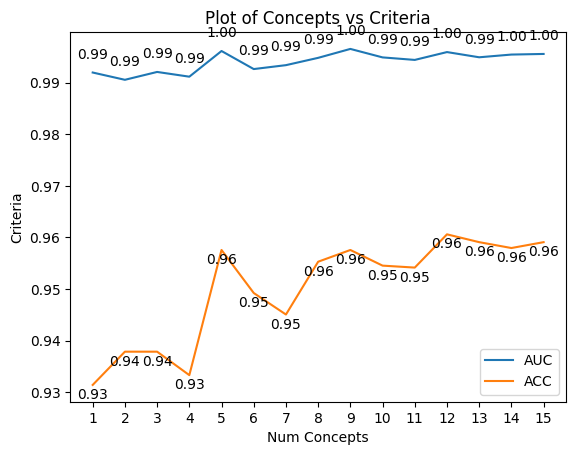

In [14]:
# plot
plt.plot(history_binary[:, 0], history_binary[:, 2], label='AUC')
plt.plot(history_binary[:, 0], history_binary[:, 3], label='ACC')

plt.xlabel('Num Concepts')
plt.ylabel('Criteria')
plt.title('Plot of Concepts vs Criteria')
plt.xticks(np.arange(min(history_binary[:, 0]), max(history_binary[:, 0])+1, 1))

for x,_y in zip(history_binary[:, 0], history_binary[:, 2]):
    label = "{:.2f}".format(_y)
    plt.annotate(label, # this is the text
                 (x,_y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for x,_y in zip(history_binary[:, 0], history_binary[:, 3]):
    label = "{:.2f}".format(_y)
    plt.annotate(label, # this is the text
                 (x,_y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.legend()
plt.show()


In [15]:
# feature weights
n_concepts = 4
_, _, _, model = objective_binary(random_seed, n_concepts, model_path)

for name, param in model.named_parameters():
    if "bottleneck.weight" in name:
        bottleneck_weights = param
feature_weights = bottleneck_weights.cpu().detach().numpy()

feature_weights.shape

Loaded model from /workdir/optimal-summaries-public/vasopressor/models/arabic/binary/arabic_c4.pt


0it [00:00, ?it/s]


(4, 182)

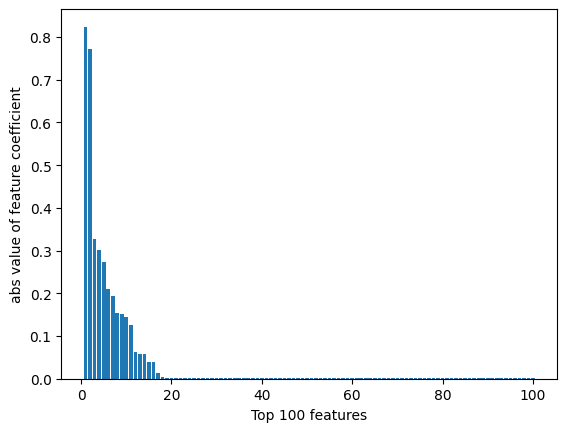

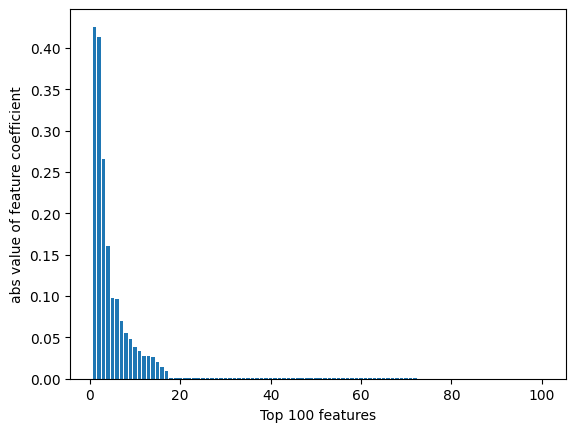

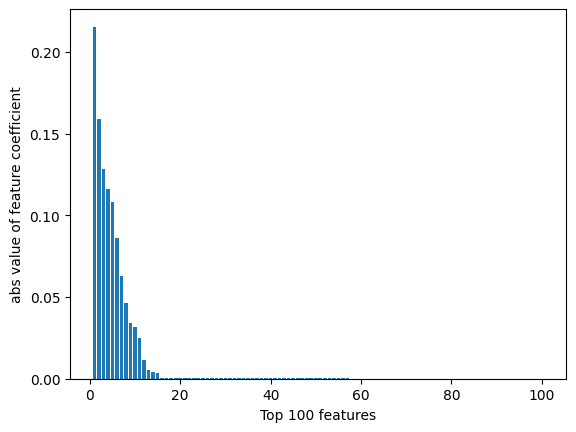

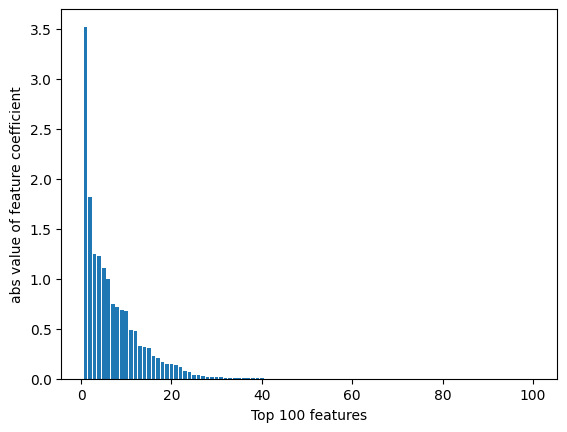

In [16]:
# visualize weight magnitudes
for c in range(n_concepts):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    inds = np.argsort(-np.abs(feature_weights[c]))[:100]
    ax.bar(np.arange(1,101),np.abs(feature_weights[c])[inds])
    ax.set_xlabel("Top 100 features")
    ax.set_ylabel("abs value of feature coefficient")
    plt.show()


In [17]:
# get 90th percentile of feature weights
sum90p = np.sum(np.abs(feature_weights), axis=-1)*0.90
sum90p.shape


(4,)

In [18]:
# get top K indizes
top_k_inds = []
for c in range(n_concepts):
    topkinds_conc = []
    curr_sum = 0
    inds = np.argsort(-np.abs(feature_weights[c])) #desc
    sorted_weights = feature_weights[c][inds]
    
    for ind, weight in zip(inds, sorted_weights):
        curr_sum += abs(weight)
        if curr_sum <= sum90p[c]:
            topkinds_conc.append(ind)
        else:
            break
    
    # if selects less than 10, choose 10 best
    # if len(topkinds_conc) < 10:
    #     topkinds_conc = np.argsort(-np.abs(feature_weights[c]))[:10].tolist()
    
    top_k_inds.append(topkinds_conc)

top_k_inds

[[27, 174, 51, 47, 45, 49, 46, 50, 35, 43],
 [174, 47, 27, 46, 45, 49, 44, 41, 48, 42],
 [46, 48, 51, 43, 27, 49, 50, 40],
 [34, 32, 91, 38, 92, 35, 178, 31, 26, 165, 93, 164, 177, 169]]

In [19]:
# write top k inds to csv
filename = experiment_folder + "top-k/top_k_inds_c{}.csv".format(n_concepts)

directory = os.path.dirname(filename)
if not os.path.exists(directory):
    os.makedirs(directory)

# writing to csv file 
with open(filename, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    # writing the data rows 
    csvwriter.writerows(top_k_inds)


## Multi-class

In [20]:
experiment_folder = "/workdir/optimal-summaries-public/vasopressor/models/arabic/multiclass/"
model_path = experiment_folder + "arabic_c{}.pt"
random_seed = 1

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

In [21]:
history_multiclass = []
for n_concepts in range(1,16):
    print(n_concepts)
    val_loss, auc, acc, model = objective_multi_class(random_seed, n_concepts, model_path)
    history = [n_concepts, val_loss, auc, acc]
    history_multiclass.append(np.array(history))
history_multiclass = np.array(history_multiclass)
history_multiclass.shape


1


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [06:16<00:00,  2.66it/s]


2


100%|██████████| 1000/1000 [07:08<00:00,  2.34it/s]


3


100%|██████████| 1000/1000 [07:06<00:00,  2.34it/s]


4


100%|██████████| 1000/1000 [07:07<00:00,  2.34it/s]


5


100%|██████████| 1000/1000 [07:09<00:00,  2.33it/s]


6


100%|██████████| 1000/1000 [07:08<00:00,  2.33it/s]


7


100%|██████████| 1000/1000 [07:07<00:00,  2.34it/s]


8


100%|██████████| 1000/1000 [07:08<00:00,  2.33it/s]


9


100%|██████████| 1000/1000 [07:08<00:00,  2.33it/s]


10


100%|██████████| 1000/1000 [07:07<00:00,  2.34it/s]


11


100%|██████████| 1000/1000 [07:06<00:00,  2.35it/s]


12


100%|██████████| 1000/1000 [07:07<00:00,  2.34it/s]


13


100%|██████████| 1000/1000 [07:07<00:00,  2.34it/s]


14


100%|██████████| 1000/1000 [07:07<00:00,  2.34it/s]


15


100%|██████████| 1000/1000 [07:06<00:00,  2.34it/s]


(15, 4)

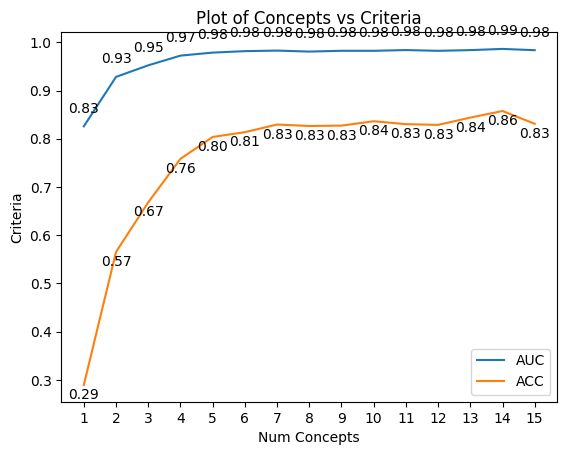

In [22]:
# plot
plt.plot(history_multiclass[:, 0], history_multiclass[:, 2], label='AUC')
plt.plot(history_multiclass[:, 0], history_multiclass[:, 3], label='ACC')

plt.xlabel('Num Concepts')
plt.ylabel('Criteria')
plt.title('Plot of Concepts vs Criteria')
plt.xticks(np.arange(min(history_multiclass[:, 0]), max(history_multiclass[:, 0])+1, 1))

for x,_y in zip(history_multiclass[:, 0], history_multiclass[:, 2]):
    label = "{:.2f}".format(_y)
    plt.annotate(label, # this is the text
                 (x,_y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for x,_y in zip(history_multiclass[:, 0], history_multiclass[:, 3]):
    label = "{:.2f}".format(_y)
    plt.annotate(label, # this is the text
                 (x,_y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.legend()
plt.show()


In [29]:
# feature weights
n_concepts = 6
_, _, _, model = objective_multi_class(random_seed, n_concepts, model_path)

for name, param in model.named_parameters():
    if "bottleneck.weight" in name:
        bottleneck_weights = param
feature_weights = bottleneck_weights.cpu().detach().numpy()

feature_weights.shape

Loaded model from /workdir/optimal-summaries-public/vasopressor/models/arabic/multiclass/arabic_c6.pt


0it [00:00, ?it/s]


(6, 182)

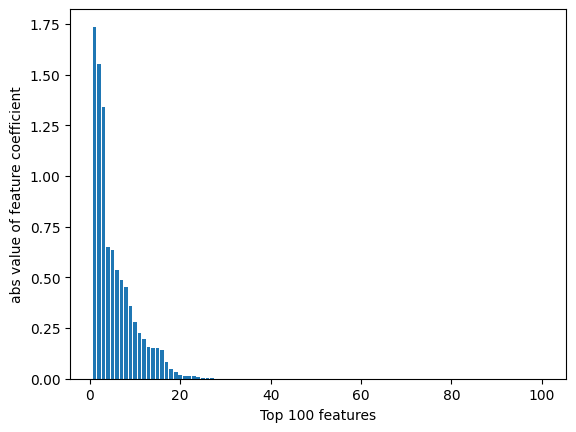

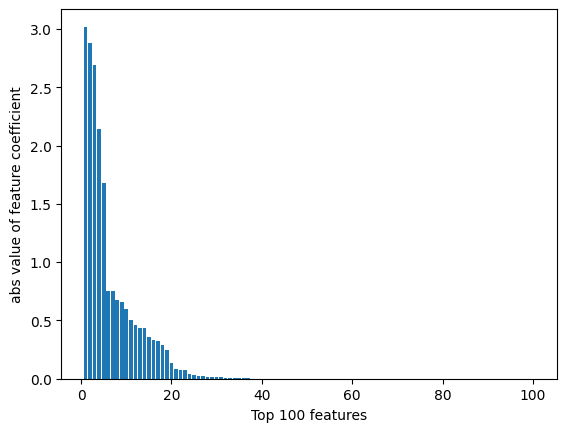

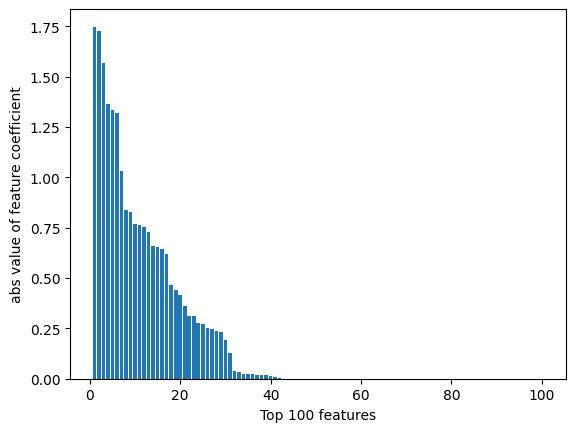

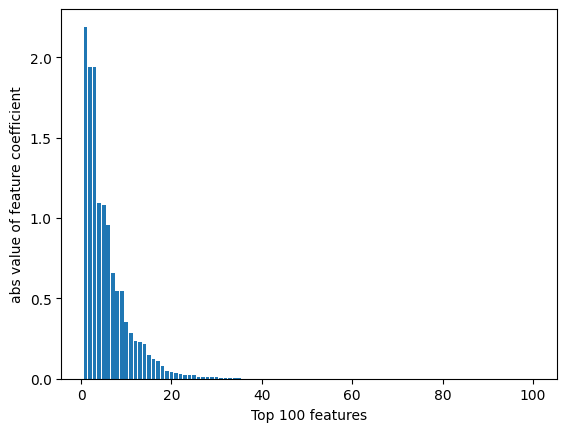

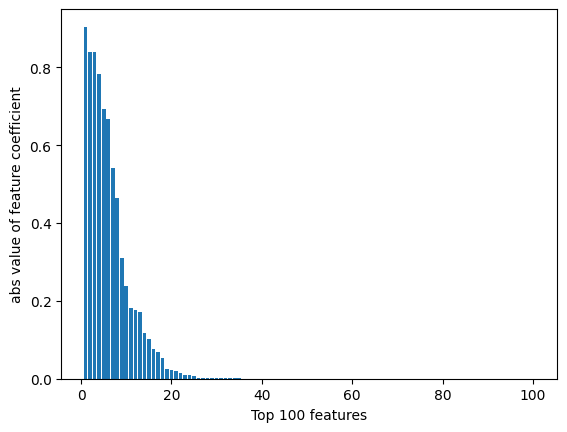

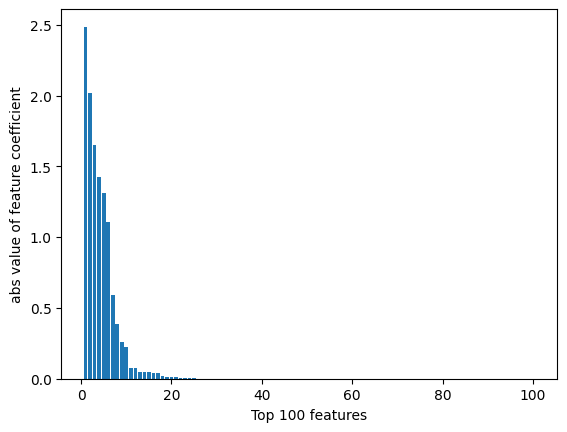

In [30]:
# visualize weight magnitudes
for c in range(n_concepts):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    inds = np.argsort(-np.abs(feature_weights[c]))[:100]
    ax.bar(np.arange(1,101),np.abs(feature_weights[c])[inds])
    ax.set_xlabel("Top 100 features")
    ax.set_ylabel("abs value of feature coefficient")
    plt.show()


In [31]:
# get 90th percentile of feature weights
sum90p = np.sum(np.abs(feature_weights), axis=-1)*0.90
sum90p.shape


(6,)

In [32]:
# get top K indizes
top_k_inds = []
for c in range(n_concepts):
    topkinds_conc = []
    curr_sum = 0
    inds = np.argsort(-np.abs(feature_weights[c])) #desc
    sorted_weights = feature_weights[c][inds]
    
    for ind, weight in zip(inds, sorted_weights):
        curr_sum += abs(weight)
        if curr_sum <= sum90p[c]:
            topkinds_conc.append(ind)
        else:
            break
    
    # if selects less than 10, choose 10 best
    # if len(topkinds_conc) < 10:
    #     topkinds_conc = np.argsort(-np.abs(feature_weights[c]))[:10].tolist()
    
    top_k_inds.append(topkinds_conc)

str(top_k_inds)

'[[28, 30, 32, 33, 160, 91, 173, 35, 37, 31, 176], [34, 31, 36, 26, 91, 32, 92, 37, 174, 161, 175, 30, 93, 177], [27, 32, 172, 30, 170, 179, 156, 178, 38, 157, 29, 174, 36, 35, 33, 173, 181, 166, 176, 171, 169, 158], [28, 26, 33, 31, 30, 158, 173, 27, 157, 163, 38], [26, 27, 30, 38, 175, 92, 28, 162, 164, 34, 29], [29, 32, 34, 28, 33, 26, 30]]'

In [33]:
# write top k inds to csv
filename = experiment_folder + "top-k/top_k_inds_c{}.csv".format(n_concepts)

directory = os.path.dirname(filename)
if not os.path.exists(directory):
    os.makedirs(directory)

# writing to csv file 
with open(filename, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    # writing the data rows 
    csvwriter.writerows(top_k_inds)


In [34]:
input_dim = 26
changing_dim = 13
data_cols = [i for i in range(1,14)] + [str(i) + "_ind" for i in range(1,14)]

for c, _list in enumerate(top_k_inds):
    for ind in _list:
        name, summary = helper.getConcept(data_cols, input_dim, changing_dim, int(ind))
        print(f"Concept {c}: ID {ind}, Feature {name}, Summary {summary}")


Concept 0: ID 28, Feature 3, Summary mean
Concept 0: ID 30, Feature 5, Summary mean
Concept 0: ID 32, Feature 7, Summary mean
Concept 0: ID 33, Feature 8, Summary mean
Concept 0: ID 160, Feature 5, Summary hours above threshold
Concept 0: ID 91, Feature 1, Summary # switches
Concept 0: ID 173, Feature 5, Summary hours below threshold
Concept 0: ID 35, Feature 10, Summary mean
Concept 0: ID 37, Feature 12, Summary mean
Concept 0: ID 31, Feature 6, Summary mean
Concept 0: ID 176, Feature 8, Summary hours below threshold
Concept 1: ID 34, Feature 9, Summary mean
Concept 1: ID 31, Feature 6, Summary mean
Concept 1: ID 36, Feature 11, Summary mean
Concept 1: ID 26, Feature 1, Summary mean
Concept 1: ID 91, Feature 1, Summary # switches
Concept 1: ID 32, Feature 7, Summary mean
Concept 1: ID 92, Feature 2, Summary # switches
Concept 1: ID 37, Feature 12, Summary mean
Concept 1: ID 174, Feature 6, Summary hours below threshold
Concept 1: ID 161, Feature 6, Summary hours above threshold
Concep